In [2]:
import urllib.request
import os
from geopandas import GeoDataFrame
import geopandas
import matplotlib.pylab as plt
import requests
import pandas as pd
import io
import shapely
from fiona.crs import from_epsg
from geopandas.tools import sjoin

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h3>1.1: Read in NYC PUMA data and create Geopandas DF</h3>

In [3]:
os.chdir(os.getenv("PUIDATA"))

In [4]:
urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile", 
                           "Public Use Microdata Areas (PUMA).zip")

('Public Use Microdata Areas (PUMA).zip',
 <http.client.HTTPMessage at 0x7f63ee74db70>)

In [5]:
!unzip "Public Use Microdata Areas (PUMA).zip"

Archive:  Public Use Microdata Areas (PUMA).zip
  inflating: geo_export_8d9faacc-18d5-4b45-af67-4d385d103646.dbf  
  inflating: geo_export_8d9faacc-18d5-4b45-af67-4d385d103646.shp  
  inflating: geo_export_8d9faacc-18d5-4b45-af67-4d385d103646.shx  
  inflating: geo_export_8d9faacc-18d5-4b45-af67-4d385d103646.prj  


In [6]:
pumashp = geopandas.GeoDataFrame.from_file("geo_export_137a76bd-8af0-42ce-a6f7-9f12cde5cc40.shp")
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [7]:
pumashp.crs

{'init': 'epsg:4326'}

<h3>1.2: Plotting PUMA geodataframe for New York</h3>

Text(0.5,1,'New York City Census Borough PUMAs')

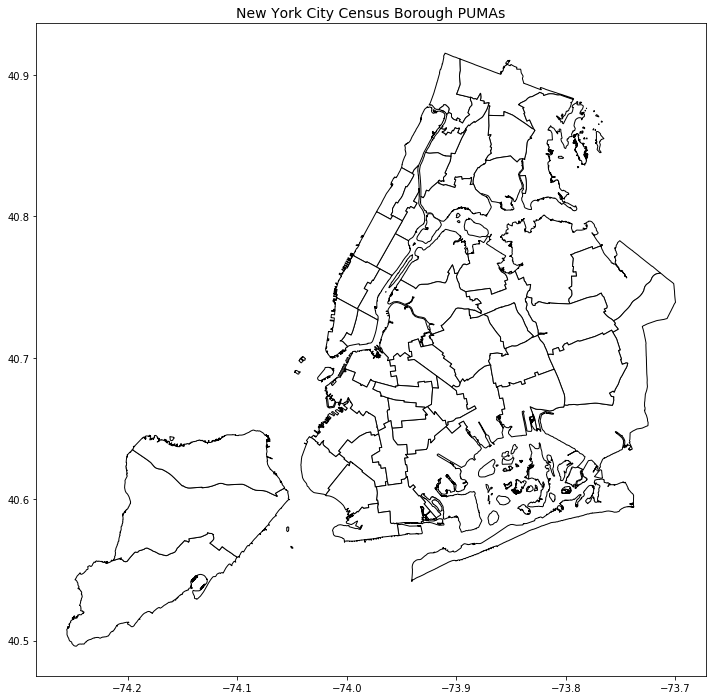

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
pumashp.plot(color='white', edgecolor='black', ax=ax)
ax.set_title('New York City Census Borough PUMAs', fontsize=14)

<b>Figure 1:</b> Geospatial map of New York City Census Borough PUMAs. No fill - border lines only shown.

<h3>2.1: Get data with American Fact Finder API</h3>

In [9]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = resp.json()

In [10]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [11]:
affkeys

array(['C27012_018E', 'B24010E_040M', 'B23002F_027M', ..., 'B24125_204MA',
       'B17001B_024M', 'B23002G_050E'], 
      dtype='<U15')

In [12]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Inter

In [72]:
#keyword for the number of households
keyNhouseholds = 'B28002_001M'
aff1y['variables'][keyNhouseholds]

{'attribute of': 'B28002_001E',
 'attribute type': 'Margin of Error',
 'attributes': 'B28002_001MA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Margin of Error!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [13]:
# getting the broadband access number of households
keyNBB = 'B28002_004E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
# getting the total number of households
keyNBB2 = 'B28002_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB2 +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


<h3>2.2: Generate a feature for the percentage of households with broadband access</h3>

In [15]:
pumaBB = pumaBB.merge(pumaPP[['NAME', 'B28002_001E']], on='NAME')

In [16]:
pumaBB['pcBB'] = pumaBB['B28002_004E'] / pumaBB['B28002_001E'] * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


<h3>2.3: Now compare it with the AFF published "percentage of households with broadband access"</h3>

In [21]:
bbpc = pd.read_csv("https://raw.githubusercontent.com/sgo230/PUI2017_sgo230/master/HW9_sgo230/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6


In [22]:
# Remove second column header
bbpc.drop(0, inplace=True)

In [23]:
# Convert column types and clean up gid column amount
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc['HC01'] = bbpc['HC01'].astype(float)
bbpc['HC02'] = bbpc['HC02'].astype(float)
bbpc["gid"] = bbpc['GCT_STUB.target-geo-id2'] - 3600000

In [25]:
# Merge and compare
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


<h3>3.1: Merge with the Puma geodataframa and plot a choropleth of the percentage of households with broadband access</h3>

In [26]:
# Convert type and merge
pumashp["puma"] = pumashp["puma"].astype(int)
pumashp = pumashp.merge(pumaBB, left_on="puma", right_on="public use microdata area")

In [27]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612


Text(0.5,1,'New York City Census Borough PUMAs')

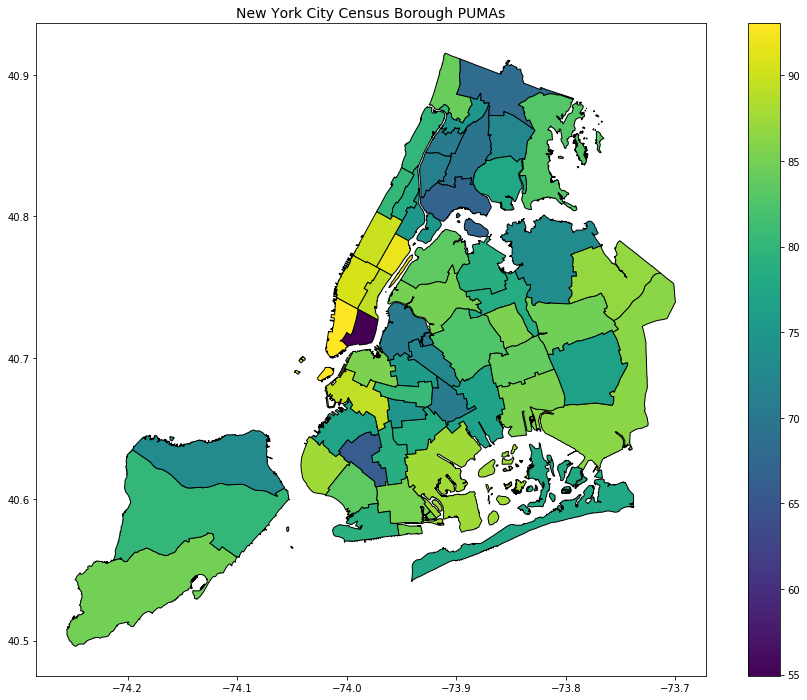

In [86]:
fig, ax = plt.subplots(figsize=(15,12))
pumashp.plot(column='pcBB', edgecolor='black', ax=ax, cmap='viridis', legend=True)
ax.set_title('New York City Census Borough PUMAs', fontsize=14)

<b>Figure 2:</b> Geospatial choropleth of New York City Census Borough PUMAs colored by household access to broadband internet (by ACS 2016 estimates). Broadband access rates are highest in Lower Manhattan, Midtown, and the Upper West and Upper East Side. Rates are noticeably low in Chinatown/Lower East Side and much of the Bronx.

<h3>4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.</h3>

In [28]:
# Get link locations csv
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

In [30]:
# Create Shapely point from lat/long
linkNYC['lonlat'] = list(zip(linkNYC['longitude'], linkNYC['latitude']))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [34]:
linkNYC['date_link'] = pd.to_datetime(linkNYC['date_link_'], format='%Y/%m/%d')
linkNYC['date_since'] = (pd.Timestamp("Today") - linkNYC['date_link']).dt.days

In [36]:
# Reduce dataframe and convert to gdf
linkNYC = linkNYC[['link_site', 'longitude', 'latitude', 'date_since', 'lonlat', 'geometry']]
linkNYC = GeoDataFrame(linkNYC)
linkNYC.crs = from_epsg(4326)

In [37]:
linkNYC.head()

,link_site,longitude,latitude,date_since,lonlat,geometry
0,bk-01-138951,-73.942489,40.701668,144,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,40.701542,144,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,40.701930,144,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,40.705060,208,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,40.728133,236,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [38]:
# Create five even intervals
max_val = pumashp['pcBB'].max()
min_val = pumashp['pcBB'].min()
interval = (max_val - min_val) / 5
intervals = []
for elem in range(5):
    intervals.append(str(round(min_val + interval * elem,2)) + '-' + str(round(min_val + interval * (elem + 1),2)))
intervals

['54.93-62.55', '62.55-70.17', '70.17-77.79', '77.79-85.41', '85.41-93.03']

In [39]:
# Bucket data into appropriate interval
pumashp['interval'] = intervals[0]
pumashp['interval'][pumashp['pcBB'] >= 85.41] = intervals[4]
pumashp['interval'][(pumashp['pcBB'] < 85.41) & (pumashp['pcBB'] >= 77.79)] = intervals[3]
pumashp['interval'][(pumashp['pcBB'] < 77.79) & (pumashp['pcBB'] >= 70.17)] = intervals[2]
pumashp['interval'][(pumashp['pcBB'] < 70.17) & (pumashp['pcBB'] >= 62.55)] = intervals[1]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/

In [40]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB,interval
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,77.79-85.41
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,62.55-70.17
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,77.79-85.41
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,70.17-77.79
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,62.55-70.17


Text(0.5,1,'New York City Census Borough PUMAs by Household Broadband Access and Location of LinkNYC')

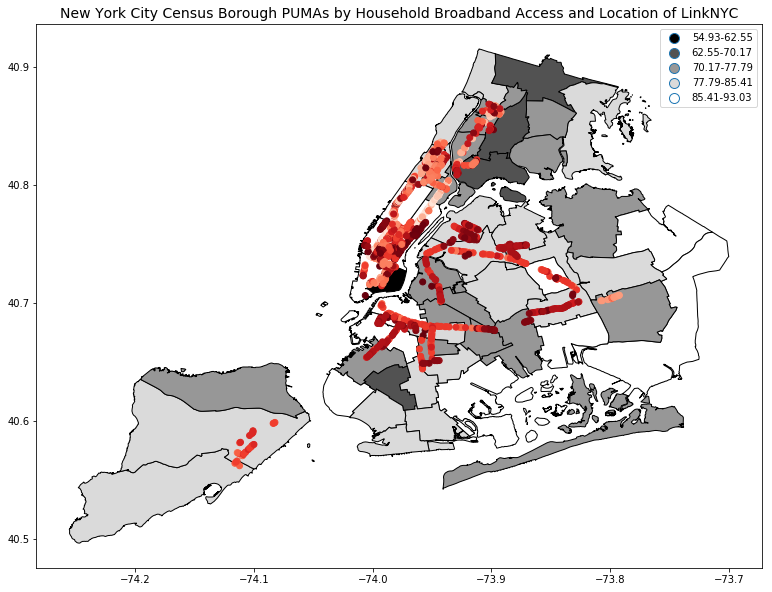

In [42]:
# Plot LinkNYC locations and broadband access together
fig, ax = plt.subplots(figsize=(13,10))
pumashp.plot(column='interval', edgecolor='black', ax=ax, cmap='Greys_r', legend=True)
linkNYC.plot(column='date_since', ax=ax, cmap='Reds_r')
ax.set_title('New York City Census Borough PUMAs by Household Broadband Access and Location of LinkNYC', fontsize=14)

<b>Figure 3</b>: New York City PUMAs in 5 equal groups of broadband access. Atop are LinkNYC locations, color-coded by date of installation.

<h3>5.1: Get population by PUMA from API and merge to geodataframe</h3>

In [52]:
# Get the population by PUMA
keyNBB3 = 'B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB3 +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [53]:
# Merge with geodataframe
pumashp = pumashp.merge(pumaPop[['B00001_001E', 'public use microdata area']], on='public use microdata area')
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB,interval,B00001_001E
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,77.79-85.41,1517
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,62.55-70.17,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,77.79-85.41,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,70.17-77.79,1882
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,62.55-70.17,2011


<h3>5.2 find the number of station per 100 people per PUMA</h3>

In [54]:
# Convert coordinate plane
linkNYC = linkNYC.to_crs(from_epsg(2263))
pumashp = pumashp.to_crs(from_epsg(2263))

In [55]:
# Group by and clean up for merge
linkpp = sjoin(pumashp, linkNYC).groupby(['puma']).size()
linkpp = linkpp.reset_index()
linkpp.columns = ['puma', 'link_site']
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [66]:
# Merge and create LinkNYC/100 people column
pumashplc = pumashp.merge(linkpp, on='puma', how='left')
pumashplc["linkNYCp100p"] = pumashplc['link_site'] / pumashplc['B00001_001E'] * 100

In [67]:
pumashplc["linkNYCp100p"].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [68]:
# Get interval range
max_val = pumashplc['linkNYCp100p'].max()
min_val = 0 #pumashplc['linkNYCp100p'].min()
interval = (max_val - min_val) / 10
intervals = []
for elem in range(10):
    intervals.append(str(round(min_val + interval * elem,2)) + '-' + str(round(min_val + interval * (elem + 1),2)))
intervals

['0.0-1.51',
 '1.51-3.03',
 '3.03-4.54',
 '4.54-6.06',
 '6.06-7.57',
 '7.57-9.08',
 '9.08-10.6',
 '10.6-12.11',
 '12.11-13.63',
 '13.63-15.14']

In [69]:
# Bucket value to interval
pumashplc['interval'] = intervals[0]
pumashplc['interval'][pumashplc['linkNYCp100p'] >= 13.63] = intervals[9]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 13.63) & (pumashplc['linkNYCp100p'] >= 12.11)] = intervals[8]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 12.11) & (pumashplc['linkNYCp100p'] >= 10.6)] = intervals[7]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 10.6) & (pumashplc['linkNYCp100p'] >= 9.08)] = intervals[6]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 9.08) & (pumashplc['linkNYCp100p'] >= 7.57)] = intervals[5]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 7.57) & (pumashplc['linkNYCp100p'] >= 6.06)] = intervals[4]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 6.06) & (pumashplc['linkNYCp100p'] >= 4.54)] = intervals[3]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 4.54) & (pumashplc['linkNYCp100p'] >= 3.03)] = intervals[2]
pumashplc['interval'][(pumashplc['linkNYCp100p'] < 3.03) & (pumashplc['linkNYCp100p'] >= 1.51)] = intervals[2]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3

In [70]:
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB,interval,B00001_001E,link_site,linkNYCp100p
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841917932,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,0.0-1.51,1517,1.0,0.065920
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393919727,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,0.0-1.51,1959,NaN,NaN
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142088761...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,0.0-1.51,1305,NaN,NaN
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972044777,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,0.0-1.51,1882,NaN,NaN
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771971538,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,0.0-1.51,2011,1.0,0.049727


Text(0.5,1,'New York City Census Borough PUMAs by Household Broadband Access and Location of LinkNYC')

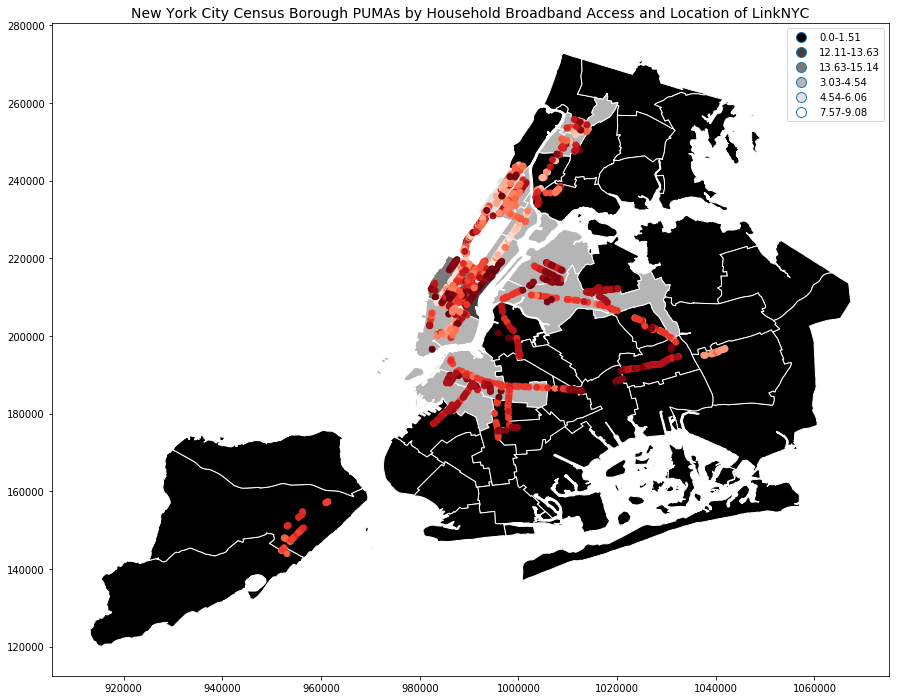

In [71]:
# Plot LinkNYC and LinkNYC/100 people on plot of NYC. Created even intervals but some fell off 
# because there are no values in them
fig, ax = plt.subplots(figsize=(15,12))
pumashplc.plot(column='interval', edgecolor='white', ax=ax, cmap='Greys_r', legend=True)
linkNYC.plot(column='date_since', ax=ax, cmap='Reds_r')
ax.set_title('New York City Census Borough PUMAs by Household Broadband Access and Location of LinkNYC', fontsize=14)

<b>Figure 4</b>: New York City PUMAs in 10 equal groups of LinkNYC kiosks per 100 residents. Atop are LinkNYC locations, color-coded by date of installation. The map is imperfect because the kiosks are concentrated in Manhattan and most of the Outer Boroughs have a value of 0.

## ASH Score 100. Extra Credit 0